In [1]:
import os
import numpy as np
import cv2 as cv
import pickle
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
from estimate_trajectory import *
data_dir = "public_tests/00_test_slam_input"
config = SFMConfig()

frame_to_image_path = get_frame_to_image_path(data_dir)
frame_to_keypoints = get_frame_to_keypoints(
        frame_to_image_path, 
        data_dir=data_dir, 
        save_dir=config.keypoints_save_dir, 
        method=config.keypoints_method,
        n_keypoints=config.n_keypoints,
        overwrite_cache=config.keypoints_overwrite_cache
    )
frame_to_extrinsic_mat = get_frame_to_extrinsic_matrix(data_dir)
anchor_frames = list(frame_to_extrinsic_mat.keys())

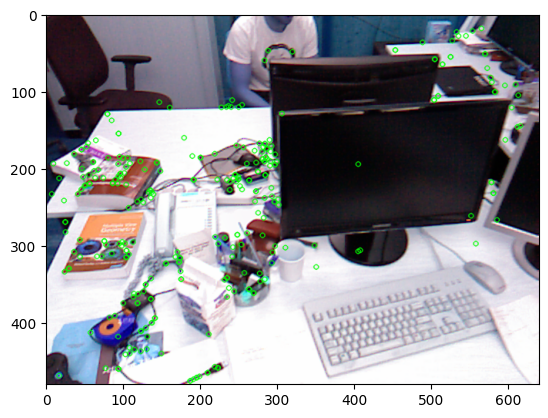

In [3]:
frame_id = 0
img = cv.imread(frame_to_image_path[frame_id])
kp = frame_to_keypoints[frame_id].kp
plt.imshow(cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0))

In [4]:
frames_to_matches = match_anchor_keypoints(
    anchor_frames, frame_to_keypoints,
    method=config.matching_method,
    ratio_threshold=config.matching_ratio_threshold
)

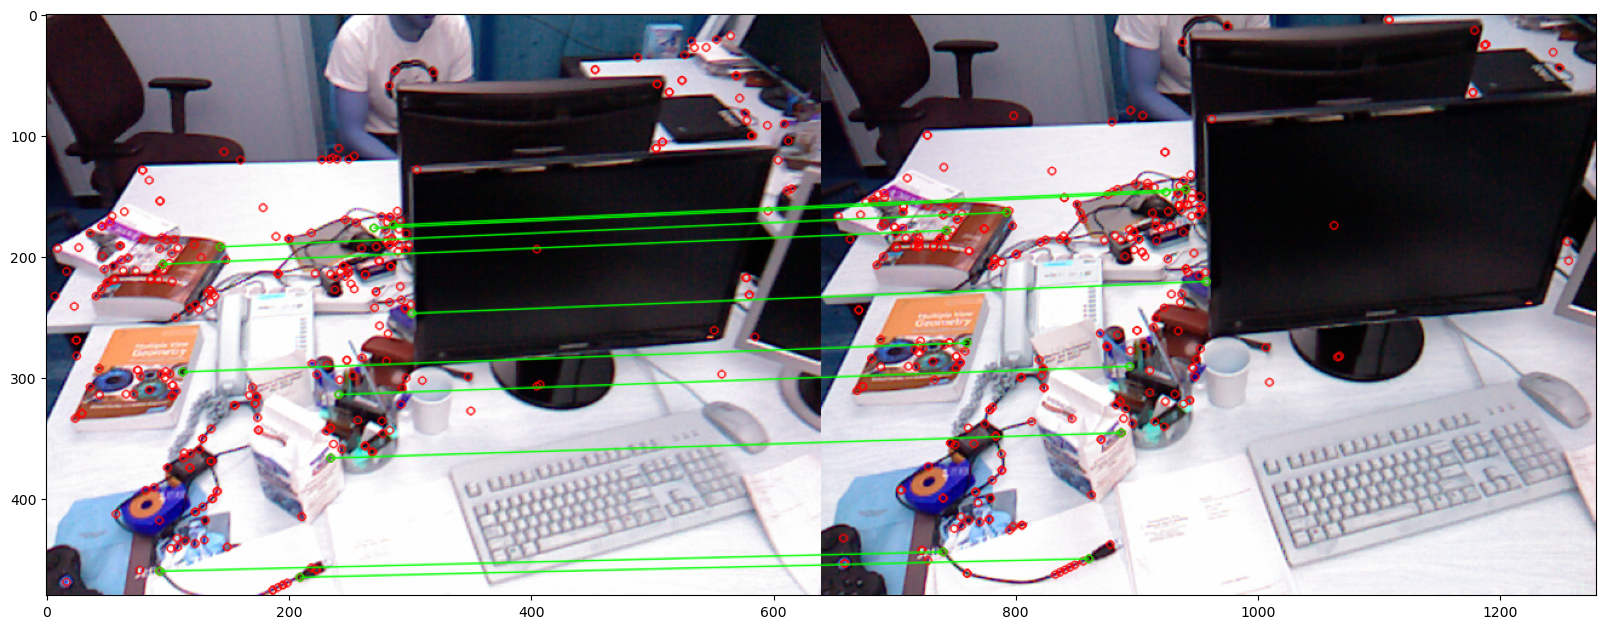

In [5]:
# frame_id1 = 0
# frame_id2 = 1
# img1 = cv.imread(frame_to_image_path[frame_id1])
# img2 = cv.imread(frame_to_image_path[frame_id2])
# kp1 = frame_to_keypoints[frame_id1].kp
# kp2 = frame_to_keypoints[frame_id2].kp
# matches = frames_to_matches[(frame_id1, frame_id2)]
# matches_to_draw = 10
# matchesMask = np.zeros((len(matches)))
# matchesMask[np.random.choice(len(matches), matches_to_draw)] = 1
# draw_params = dict(matchColor = (0,255,0),
#                    singlePointColor = (255,0,0),
#                    matchesMask=matchesMask,
#                    flags = 0)
# plt.figure(figsize=(20,20))
# plt.imshow(cv.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params))

In [5]:
tracks = get_tracks(frames_to_matches, track_min_length=config.track_min_length)
print(f"num tracks {len(tracks)}")

num tracks 1043


Track 613 of size 5


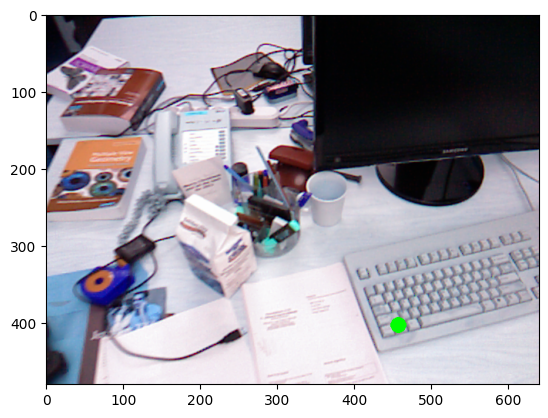

In [6]:
track_idx = np.random.choice(len(tracks)) #list(sorted(enumerate(tracks), key=lambda x: -len(x[1])))[0][0]
plot_track(frame_to_image_path, frame_to_keypoints, tracks, track_idx)

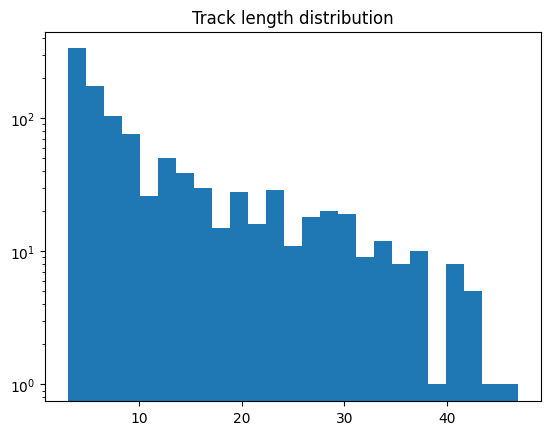

In [8]:
plt.hist([len(track.items) for track in tracks], bins=25)
plt.yscale('log')
plt.title('Track length distribution')
plt.show()

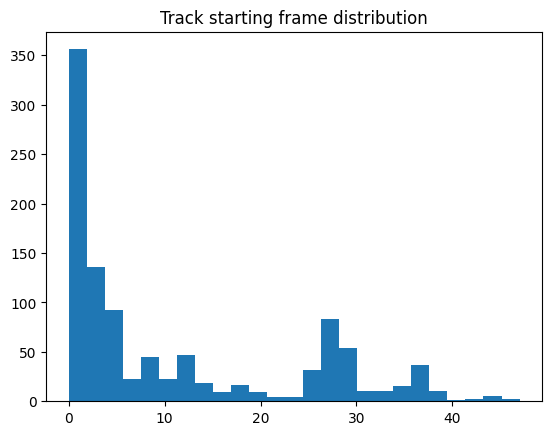

In [9]:
plt.hist([track.frames[0] for track in tracks], bins=25);
plt.title('Track starting frame distribution');

Text(0.5, 1.0, 'Frames distribution')

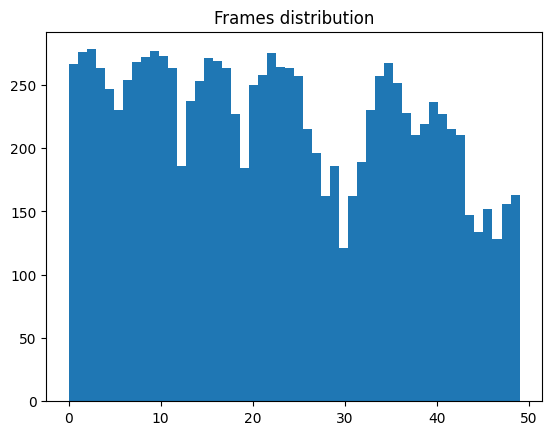

In [10]:
plt.hist(np.array([frame for track in tracks for frame in track.frames]), bins=50);
plt.title('Frames distribution')

In [11]:
intrinsics_mat = get_intrinsics_matrix(data_dir)

good_tracks, tracks_points3d = triangulate_tracks(
    tracks, frame_to_keypoints, intrinsics_mat, frame_to_extrinsic_mat,
    reproj_error_threshold=config.reproj_error_threshold
)
print(f"Found {len(good_tracks)} good tracks!")
print(f"Mean good track length {np.mean([len(t) for t in good_tracks]):.3f}")
anchor_frame_to_keypoints = get_inliers_keypoints(good_tracks, tracks_points3d, frame_to_keypoints)

Found 667 good tracks!
Mean good track length 9.325


127 127 125


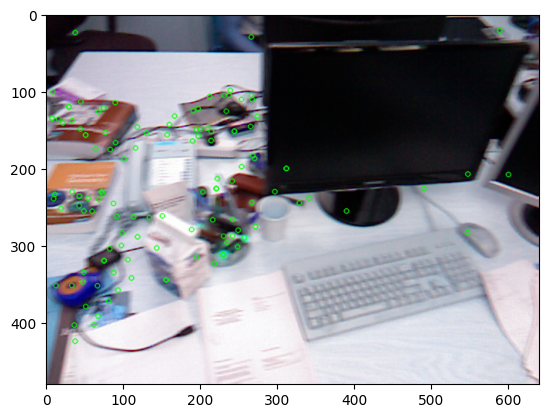

In [26]:
frame_id = 43
img = cv.imread(frame_to_image_path[frame_id])
kp = anchor_frame_to_keypoints[frame_id].kp
points3d = [tuple(point) for point in anchor_frame_to_keypoints[frame_id].points3d]
print(len(kp), len(set(kp)), len(set(points3d)))
plt.imshow(cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0))